In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Dropout, TimeDistributed
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_DATA_FILE = pd.read_csv('train.csv')
TEST_DATA_FILE = pd.read_csv('test.csv')
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 50

In [3]:
print("A quick view of training set")
TRAIN_DATA_FILE.info()

A quick view of training set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or

In [4]:
print("A quick view of testing set")
TEST_DATA_FILE.info()

A quick view of testing set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
id              97320 non-null int64
comment_text    97320 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
#TRAIN_DATA_FILE.loc[TRAIN_DATA_FILE['target'] >= 0.5, 'target'] = 1
#TRAIN_DATA_FILE.loc[TRAIN_DATA_FILE['target'] < 0.5, 'target'] = 0

In [5]:
TRAIN_DATA_FILE.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
'''
What's the positive ratio of each class ?
'''
def get_pos_ratio(data):
    return data.sum() / len(data)

pos_ratio = []
for col in ['severe_toxicity','obscene','identity_attack','insult','threat','sexual_explicit']:
    pos_ratio.append(get_pos_ratio(TRAIN_DATA_FILE[col]))

In [6]:
data_train = TRAIN_DATA_FILE[{'severe_toxicity','obscene','identity_attack','insult','threat','sexual_explicit'}]
#data_train = TRAIN_DATA_FILE[{'target'}]

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 6 columns):
obscene            float64
threat             float64
insult             float64
sexual_explicit    float64
severe_toxicity    float64
identity_attack    float64
dtypes: float64(6)
memory usage: 82.6 MB


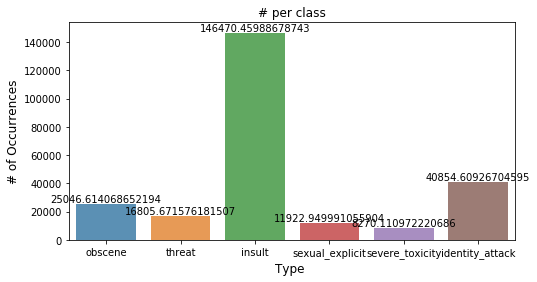

In [9]:
x = data_train.iloc[:,:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

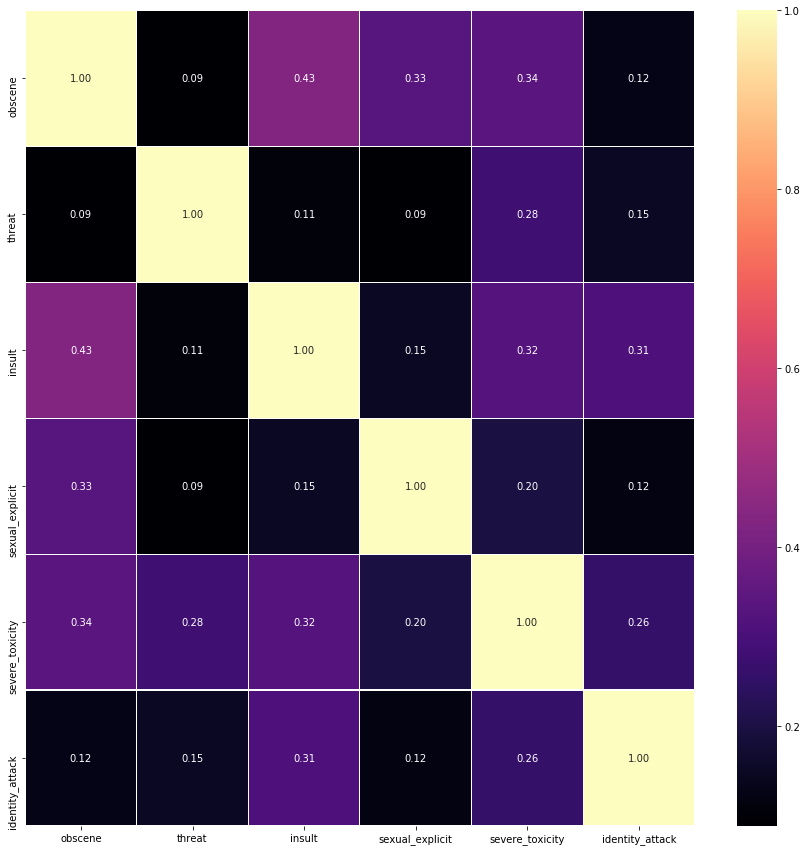

In [10]:
import seaborn as sns
corr = data_train.corr()
fig,ax=plt.subplots(figsize=(15,15))
sns.heatmap(corr,ax=ax,annot=True,linewidths=0.05,fmt='.2f',cmap="magma")
plt.savefig("correlated_heat_map.png")
plt.show()

In [11]:
########################################
## Text pre-processing and cleaning
########################################
print('Processing text dataset')
from collections import defaultdict

# regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

# regex to replace all numeric
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def clean_text(text, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    text = special_character_removal.sub('',text)
    
    return text

Processing text dataset


In [12]:
'''
Apply preprocessing and extract the training sentences and testing senteces from pandas dataframe.
Note that there are some N/A comment in the train/test set. Fill them up first.
'''
train_comments = []
test_comments = []

In [13]:
list_sentences_train = TRAIN_DATA_FILE["comment_text"].fillna("no comment").values
list_classes = ["severe_toxicity","obscene","identity_attack","insult","threat","sexual_explicit"]
train_labels = TRAIN_DATA_FILE[list_classes].values
list_sentences_test =  TEST_DATA_FILE["comment_text"].fillna("no comment").values

train_comments = [clean_text(text) for text in list_sentences_train]
test_comments = [clean_text(text) for text in list_sentences_test]

In [22]:
len(test_comments)

97320

97320

In [23]:
for i in range(3):
    print("Cleaned\n", train_comments[i] + '\n')
    print("Raw\n", TRAIN_DATA_FILE.iloc[i]['comment_text'] + '\n')
    print("------------------")

Cleaned
 this is so cool it is like would you want your mother to read this really great idea well done

Raw
 This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!

------------------
Cleaned
 thank you this would make my life a lot less anxiety inducing keep it up and do not let anyone get in your way

Raw
 Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!

------------------
Cleaned
 this is such an urgent design problem kudos to you for taking it on very impressive

Raw
 This is such an urgent design problem; kudos to you for taking it on. Very impressive!

------------------


In [24]:
# Create a tokenize, which transforms a sentence to a list of ids
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# Build the relation between words and ids 
tokenizer.fit_on_texts(train_comments + test_comments)

In [18]:
print(tokenizer.word_index['it']) # map 'the' to 1, map 'to' to 2,......
print(tokenizer.word_index['fuck'])

10
10435


In [25]:
# Transform training/testing sentences to training/testing sequences.
train_sequences = tokenizer.texts_to_sequences(train_comments)
test_sequences = tokenizer.texts_to_sequences(test_comments)

In [26]:
for i in range(2):
    print("Transformed\n", str(train_sequences[i]) + '\n')
    print("Cleaned\n", train_comments[i] + '\n')
    print("------------------")

Transformed
 [19, 3, 37, 2172, 10, 3, 50, 32, 12, 104, 38, 1039, 2, 184, 19, 123, 161, 343, 96, 215]

Cleaned
 this is so cool it is like would you want your mother to read this really great idea well done

------------------
Transformed
 [384, 12, 19, 32, 94, 59, 163, 6, 217, 218, 6443, 17032, 179, 10, 55, 4, 22, 9, 145, 192, 60, 7, 38, 97]

Cleaned
 thank you this would make my life a lot less anxiety inducing keep it up and do not let anyone get in your way

------------------


In [27]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', train_labels.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor:', test_data.shape)

Found 466808 unique tokens
Shape of data tensor: (1804874, 100)
Shape of label tensor: (1804874, 6)
Shape of test_data tensor: (97320, 100)


In [28]:
########################################
## Define the text rnn model structure
########################################
def get_text_rnn():
    recurrent_units = 48
    dense_units = 32
    output_units = 6
    
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(GRU(recurrent_units, return_sequences=False))(x)
    
    x = Dense(dense_units, activation="relu")(x)
    output_layer = Dense(output_units, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
########################################
## Define the text cnn model structure
########################################
def get_text_cnn():
    filter_nums = 120
    dense_units = 72
    output_units = 6
    
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,trainable=False,)(input_layer)
        
    conv_0 = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_1 = Conv1D(filter_nums, 3, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_2 = Conv1D(filter_nums, 4, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)

    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=dense_units, activation="relu")(merged_tensor)
    output = Dense(units=output_units, activation='sigmoid')(h1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("JUST FINISHED COMPILING THE MODEL CNN")
    return model

In [30]:
########################################
## Define the text hybrid model structure
########################################
def get_hybrid_textnn():
    recurrent_units = 48
    dense_units = 32
    filter_nums = 64
    output_units = 6

    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(x)    
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(output_units, activation="sigmoid")(max_pool)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
########################################
## Construct the cross-validation framework
########################################
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    # set an early stopping checker.
    # the training phase would stop when validation log loss decreases continuously for `patience` rounds. 
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "ToxicModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=50, batch_size=batch_size, shuffle=True,
        callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
    model.load_weights(bst_model_path)

    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(X, y, fold_count, batch_size, get_model_func):
    fold_size = len(X) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to `fold_count` fold, and train our model on each fold
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size

        if fold_id == fold_size - 1:
            fold_end = len(X)

        # Generate the train/val data on fold i
        train_x = np.concatenate([X[:fold_start], X[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])

        val_x = X[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
    
        print("Training on fold #", fold_id)
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [32]:
models, val_loss = train_folds(train_data, train_labels, 2, 256, get_text_cnn)

Training on fold # 0
Instructions for updating:
Colocations handled automatically by placer.
JUST FINISHED COMPILING THE MODEL CNN
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 902437 samples, validate on 902437 samples
Epoch 1/50
902437/902437 [==============================] - 763s 846us/step - loss: 0.0963 - acc: 0.8959 - val_loss: 0.0870 - val_acc: 0.9004
Epoch 2/50
902437/902437 [==============================] - 1249s 1ms/step - loss: 0.0869 - acc: 0.8963 - val_loss: 0.0832 - val_acc: 0.9004
Epoch 3/50
902437/902437 [==============================] - 756s 837us/step - loss: 0.0838 - acc: 0.8963 - val_loss: 0.0822 - val_acc: 0.9004
Epoch 4/50
902437/902437 [==============================] - 750s 831us/step - loss: 0.0818 - acc: 0.8963 - val_loss: 0.0797 - val_acc: 0.9004
Epoch 5/50
902437/902437 [==============================] - 777s 861us/step - loss: 0.0804 - acc: 0.8963 - val_loss: 0.0787 

KeyboardInterrupt: 

In [58]:
#test_data = test_df
CLASSES = ["target","severe_toxicity","obscene","identity_attack","insult","threat"]
submit_path_prefix = "ToxicNN-" + str(MAX_SEQUENCE_LENGTH) 

print("Predicting testing results...")
test_predicts_list = []
for fold_id, model in enumerate(models):
    test_predicts = model.predict(test_data, batch_size=256, verbose=1)
    test_predicts_list.append(test_predicts)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_predicts_list[0].shape)
for fold_predict in test_predicts_list:
    test_predicts += fold_predict
test_predicts /= len(test_predicts_list)

# create the submission file
test_ids = TEST_DATA_FILE["id"].values
test_ids = test_ids.reshape((len(test_ids), 1))
test_predicts = pd.DataFrame(data=test_predicts, columns=CLASSES)
test_predicts["id"] = test_ids
test_predicts = test_predicts[["id"] + CLASSES]
submit_path = submit_path_prefix + "-Loss{:4f}.csv".format(val_loss)
test_predicts.to_csv(submit_path, index=False)

Predicting testing results...
97320/97320 [==============================] - 23s 234us/step


In [68]:
for i in range(10):
    print("Transformed\n", str(test_predicts['target'][i]) + '\n')
    print("Cleaned\n", TEST_DATA_FILE['comment_text'][i] + '\n')
    print("------------------")

Transformed
 0.0

Cleaned
 Jeff Sessions is another one of Trump's Orwellian choices. He believes and has believed his entire career the exact opposite of what the position requires.

------------------
Transformed
 0.0

Cleaned
 I actually inspected the infrastructure on Grand Chief Stewart Philip's home Penticton First Nation in both 2010 and 2013.  Exactly Zero projects that had been identified in previous inspection reports had been funded by the federal government, and the entire band was housed in ATCO trailers.  Clearly the Harper Conservatives had already reduced the cash his band was sent to zero.

------------------
Transformed
 0.0

Cleaned
 No it won't . That's just wishful thinking on democrats fault .   For the 100 th time , Walker cited the cost of drug users treatment as being lost with Obamacare .  I laugh every time I hear a liberal claim republicans want to hurt people , and that's why they dumped Obamacare.

------------------
Transformed
 0.0

Cleaned
 Instead of w

In [85]:
test_predicts.loc[test_predicts['target'] >= 0.5, 'target'] = 1
test_predicts.loc[test_predicts['target'] < 0.5, 'target'] = 0

In [86]:
test_predicts['target']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
97290    0.0
97291    0.0
97292    0.0
97293    0.0
97294    0.0
97295    0.0
97296    0.0
97297    0.0
97298    0.0
97299    0.0
97300    0.0
97301    0.0
97302    0.0
97303    0.0
97304    0.0
97305    0.0
97306    0.0
97307    0.0
97308    0.0
97309    0.0
97310    0.0
97311    0.0
97312    0.0
97313    0.0
97314    0.0
97315    0.0
97316    0.0
97317    0.0
97318    0.0
97319    0.0
Name: target, Length: 97320, dtype: float64

In [76]:
xxx.shape()

AttributeError: 'tuple' object has no attribute 'shape'